In [24]:
from pathlib import Path
from carps.analysis.gather_data import read_jsonl_content
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from carps.analysis.utils import setup_seaborn
from omegaconf import OmegaConf
from dacboenv.experiment.collect_incumbents import add_metadata_to_dict
from tqdm import tqdm

setup_seaborn()

log_fn = "DACBOEnvLogs.jsonl"
rundirs = [
    # "../runs_eval/SMAC-AC--dacbo_Cepisode_length_scaled_plus_logregret_AWEI-cont_Ssmart_Repisode_finished_scaled_Ibbob2d_3seeds--seed1",
    # "/scratch/hpc-prf-intexml/tklenke/experiment_runs/dacboenv_ppo_semi/runs/PPO-Perceptron-dacbo_Cepisode_length_scaled_plus_logregret_AWEI-cont_Ssmart_Repisode_finished_scaled_Ibbob2d_3seeds-1",
    # "/scratch/hpc-prf-intexml/tklenke/experiment_runs/dacboenv_ppo_semi/runs/Random",
    "../runs_statespace"
]
filenames = []
for rundir in rundirs:
    _fns = list(Path(rundir).glob(f"**/{log_fn}"))
    filenames.extend(_fns)

def load_obs(filenames: list[str]) -> tuple[pd.DataFrame, list[str]]:
    observations = []
    for rundir in tqdm(filenames):
        rundir = Path(rundir)
        cfg_fn = rundir.parent / ".hydra/config.yaml"
        cfg = OmegaConf.load(cfg_fn)
        obs = read_jsonl_content(rundir)
        obs_keys = list(obs.iloc[0]["observation"].keys())

        expanded = obs["observation"].apply(pd.Series)
        expanded.columns = obs_keys
        obs = obs.drop(columns="observation").join(expanded)
        policy_id = cfg.policy_id if hasattr(cfg, "policy_id") else rundir.parts[-8]
        obs["policy_id"] = policy_id
        obs = add_metadata_to_dict(obs, cfg)
        observations.append(obs)
    observations = pd.concat(observations).reset_index(drop=True)
    return observations, obs_keys

def apply_pca_reduction(obs, obs_keys):
    X = obs[obs_keys].to_numpy()
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    obs["X_pca"] = list(X_pca)
    expanded = obs["X_pca"].apply(pd.Series)
    expanded.columns = [f"x_{i},pca" for i in range(X_pca.shape[-1])]
    return obs.drop(columns="X_pca").join(expanded)

print(len(filenames))
obs, obs_keys = load_obs(filenames)
obs.to_csv("obs.csv")
pd.Series(obs_keys).to_csv("obs_keys.csv")



250


100%|██████████| 250/250 [00:07<00:00, 34.18it/s]


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from carps.analysis.utils import get_color_palette


def plot_time_progression_quiver(
    obs,
    x_col="x_0,pca",
    y_col="x_1,pca",
    time_col="n_trials",
    policy_col="policy_id",
    figsize=(7, 6),
    point_size=55,
    arrow_width=0.004,
):
    """Plot time progression using arrows (quiver), per policy.

    - Points show states
    - Arrows point toward the next time step
    - Start marker: hollow circle
    - End marker: X
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    policies = obs[policy_col].unique()
    policy_to_color = get_color_palette(optimizers=policies)

    for (policy_id, seed), g in obs.groupby([policy_col, "seed"]):
        # Sort by time within policy
        g = g.sort_values(time_col)

        x = g[x_col].values
        y = g[y_col].values

        if len(x) < 2:
            continue

        dx = np.diff(x)
        dy = np.diff(y)

        color = policy_to_color[policy_id]

        label = policy_id

        # Scatter points
        ax.scatter(
            x,
            y,
            s=point_size,
            color=color,
            alpha=0.8,
            label=label,
        )

        # Quiver arrows (time direction)
        ax.quiver(
            x[:-1],
            y[:-1],
            dx,
            dy,
            angles="xy",
            scale_units="xy",
            scale=1,
            width=arrow_width,
            color=color,
            alpha=0.15,
        )

        # Start marker
        ax.scatter(
            x[0],
            y[0],
            marker="o",
            s=point_size * 2.2,
            facecolors="none",
            edgecolors=color,
            linewidths=2,
        )

        # End marker
        ax.scatter(
            x[-1],
            y[-1],
            marker="X",
            s=point_size * 2.2,
            color=color,
            linewidths=2,
        )

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title("State Space (PCA(n=2))")
    ax.legend(title=policy_col, bbox_to_anchor=(1.05, 1))
    fig.tight_layout()
    plt.show()


# for task_id, group in obs.groupby("task_id"):
#     plot_time_progression_quiver(group, task_id, arrow_width=0.004)
#     # break

In [3]:
obs.columns

Index(['reward', 'n_trials', 'incumbent_changes', 'trials_passed',
       'trials_left', 'ubr', 'searchspace_dim', 'continuous_hps',
       'categorical_hps', 'ordinal_hps', 'int_hps', 'tsp', 'knn_entropy',
       'y_skewness', 'y_kurtosis', 'y_mean', 'y_std', 'y_variability',
       'tsp_best', 'knn_entropy_best', 'y_skewness_best', 'y_kurtosis_best',
       'y_mean_best', 'y_std_best', 'y_variability_best', 'budget_percentage',
       'inc_improvement_scaled', 'has_categorical_hps', 'knn_difference',
       'ubr_difference', 'gp_hp_k1__k1__constant_value0_observation',
       'gp_hp_k1__k2__length_scale0_observation',
       'gp_hp_k1__k2__length_scale1_observation',
       'gp_hp_k2__noise_level0_observation', 'policy_id', 'seed', 'task_id',
       'optimizer_id', 'reward_id', 'action_space_id', 'objective_function',
       'config'],
      dtype='object')

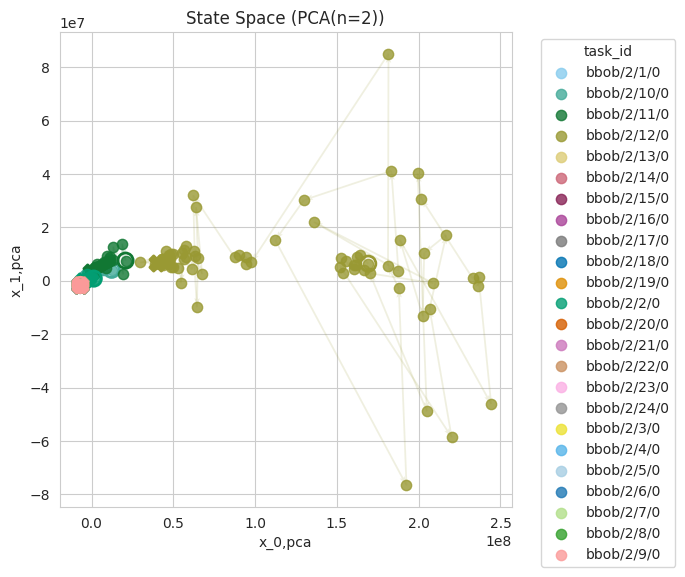

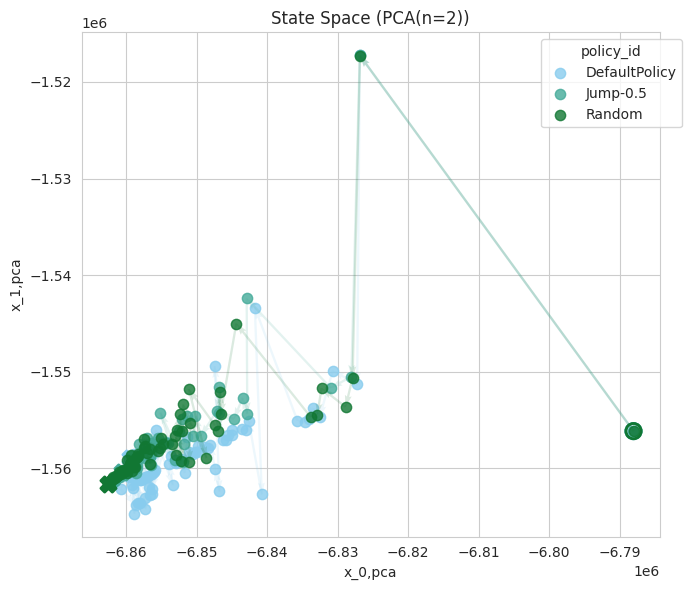

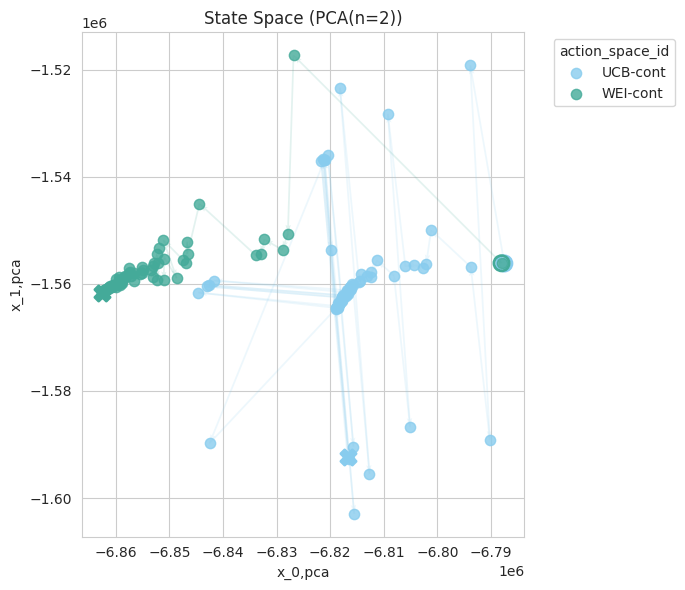

In [26]:

if "x_1,pca" not in obs.columns:
    obs = apply_pca_reduction(obs, obs_keys)

seed = 2

# (1): one optimizer (default), many functions (hue)
group = obs[
    (obs["optimizer_id"] == "DefaultPolicy") & \
    (obs["seed"] == seed) & \
    (obs["action_space_id"] == "WEI-cont")
]
plot_time_progression_quiver(group, policy_col="task_id")

# (2): one task, many optimizers
task_id = "bbob/2/20/0"
group = obs[
    (obs["task_id"] == task_id) & \
    (obs["seed"] == seed) & \
    (obs["action_space_id"] == "WEI-cont")
    # (obs["optimizer_id"] == "Jump-0.5")
]
plot_time_progression_quiver(group)

# (3): one optimizer (default), two action spaces
task_id = "bbob/2/20/0"
group = obs[
    (obs["task_id"] == task_id) & \
    (obs["seed"] == seed) & \
    # (obs["action_space_id"] == "") & \
    (obs["optimizer_id"] == "Random")
]
plot_time_progression_quiver(group, policy_col="action_space_id")



Index(['reward', 'n_trials', 'incumbent_changes', 'trials_passed',
       'trials_left', 'ubr', 'searchspace_dim', 'continuous_hps',
       'categorical_hps', 'ordinal_hps', 'int_hps', 'tsp', 'knn_entropy',
       'y_skewness', 'y_kurtosis', 'y_mean', 'y_std', 'y_variability',
       'tsp_best', 'knn_entropy_best', 'y_skewness_best', 'y_kurtosis_best',
       'y_mean_best', 'y_std_best', 'y_variability_best', 'budget_percentage',
       'inc_improvement_scaled', 'has_categorical_hps', 'knn_difference',
       'ubr_difference', 'gp_hp_k1__k1__constant_value0_observation',
       'gp_hp_k1__k2__length_scale0_observation',
       'gp_hp_k1__k2__length_scale1_observation',
       'gp_hp_k2__noise_level0_observation', 'policy_id', 'seed', 'task_id',
       'optimizer_id', 'reward_id', 'action_space_id', 'objective_function',
       'config', 'x_0,pca', 'x_1,pca'],
      dtype='object')


[15:24:53] INFO     Too many optimizers: 24 > 16. Reusing markers.                                      ]8;id=786014;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/utils.py\utils.py]8;;\:]8;id=628935;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/utils.py#47\47]8;;\

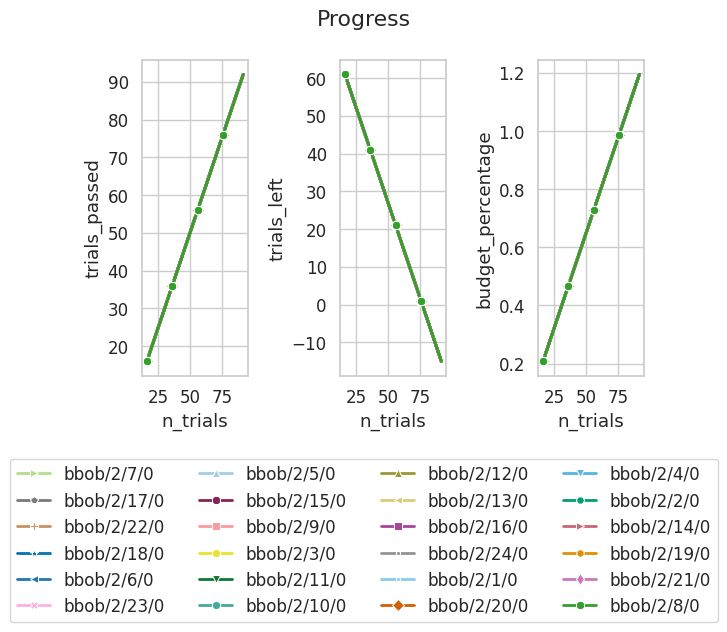

[15:25:02] INFO     Too many optimizers: 24 > 16. Reusing markers.                                      ]8;id=470588;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/utils.py\utils.py]8;;\:]8;id=323941;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/utils.py#47\47]8;;\

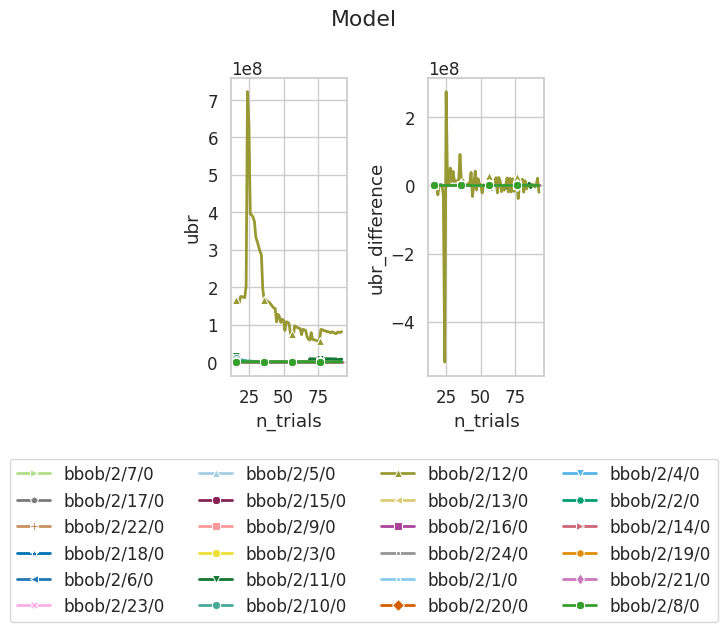

[15:25:03] INFO     Too many optimizers: 24 > 16. Reusing markers.                                      ]8;id=266351;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/utils.py\utils.py]8;;\:]8;id=528263;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/utils.py#47\47]8;;\

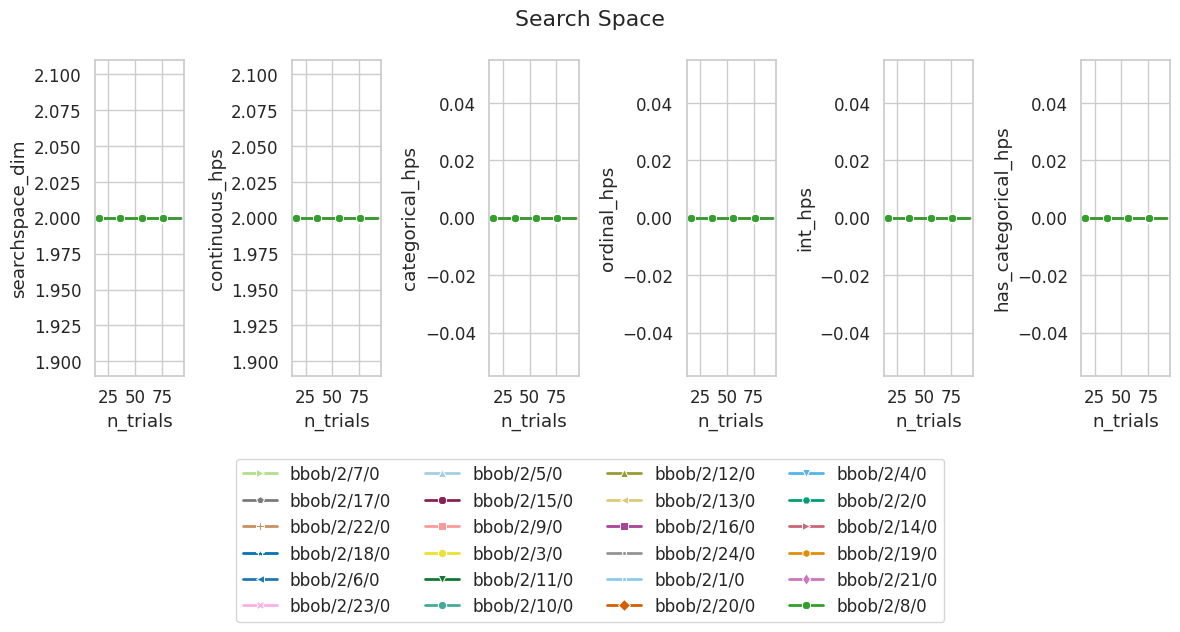

[15:25:05] INFO     Too many optimizers: 24 > 16. Reusing markers.                                      ]8;id=739596;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/utils.py\utils.py]8;;\:]8;id=36797;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/utils.py#47\47]8;;\

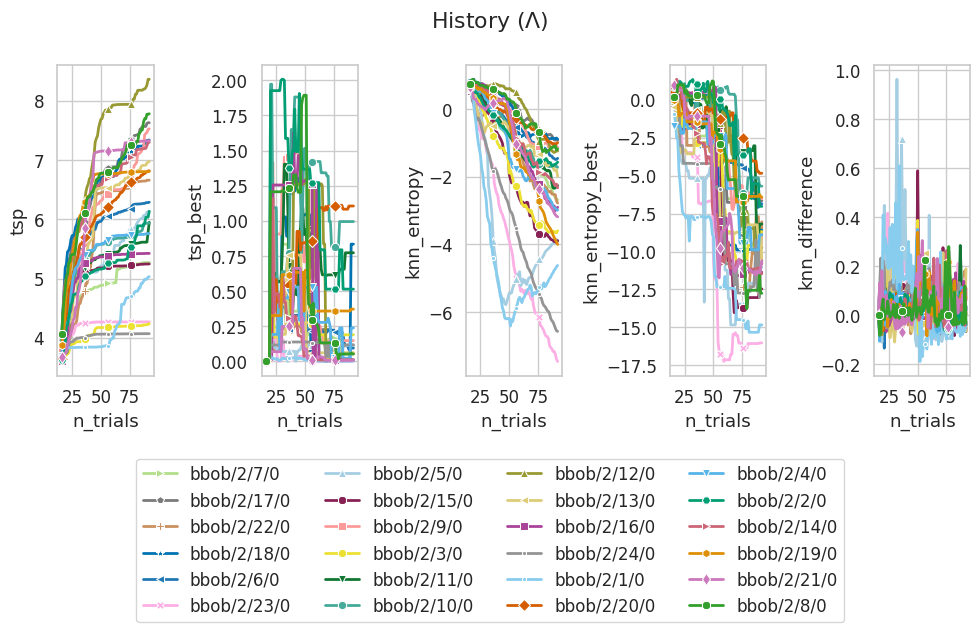

[15:25:07] INFO     Too many optimizers: 24 > 16. Reusing markers.                                      ]8;id=895125;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/utils.py\utils.py]8;;\:]8;id=153949;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/utils.py#47\47]8;;\

[15:25:10] INFO     Substituting symbol O from STIXNonUnicode                                      ]8;id=727905;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/matplotlib/_mathtext.py\_mathtext.py]8;;\:]8;id=394141;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/matplotlib/_mathtext.py#648\648]8;;\

           INFO     Substituting symbol O from STIXNonUnicode                                      ]8;id=766213;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/matplotlib/_mathtext.py\_mathtext.py]8;;\:]8;id=244020;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/matplotlib/_mathtext.py#648\648]8;;\

           INFO     Substituting symbol O from STIXNonUnicode                                      ]8;id=708240;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/matplotlib/_mathtext.py\_mathtext.py]8;;\:]8;id=733336;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/matplotlib/_mathtext.py#648\648]8;;\

[15:25:11] INFO     Substituting symbol O from STIXNonUnicode                                      ]8;id=346520;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/matplotlib/_mathtext.py\_mathtext.py]8;;\:]8;id=841398;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/matplotlib/_mathtext.py#648\648]8;;\

           INFO     Substituting symbol O from STIXNonUnicode                                      ]8;id=857625;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/matplotlib/_mathtext.py\_mathtext.py]8;;\:]8;id=578977;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/matplotlib/_mathtext.py#648\648]8;;\

[15:25:12] INFO     Substituting symbol O from STIXNonUnicode                                      ]8;id=527880;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/matplotlib/_mathtext.py\_mathtext.py]8;;\:]8;id=518469;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/matplotlib/_mathtext.py#648\648]8;;\

           INFO     Substituting symbol O from STIXNonUnicode                                      ]8;id=356207;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/matplotlib/_mathtext.py\_mathtext.py]8;;\:]8;id=239592;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/matplotlib/_mathtext.py#648\648]8;;\

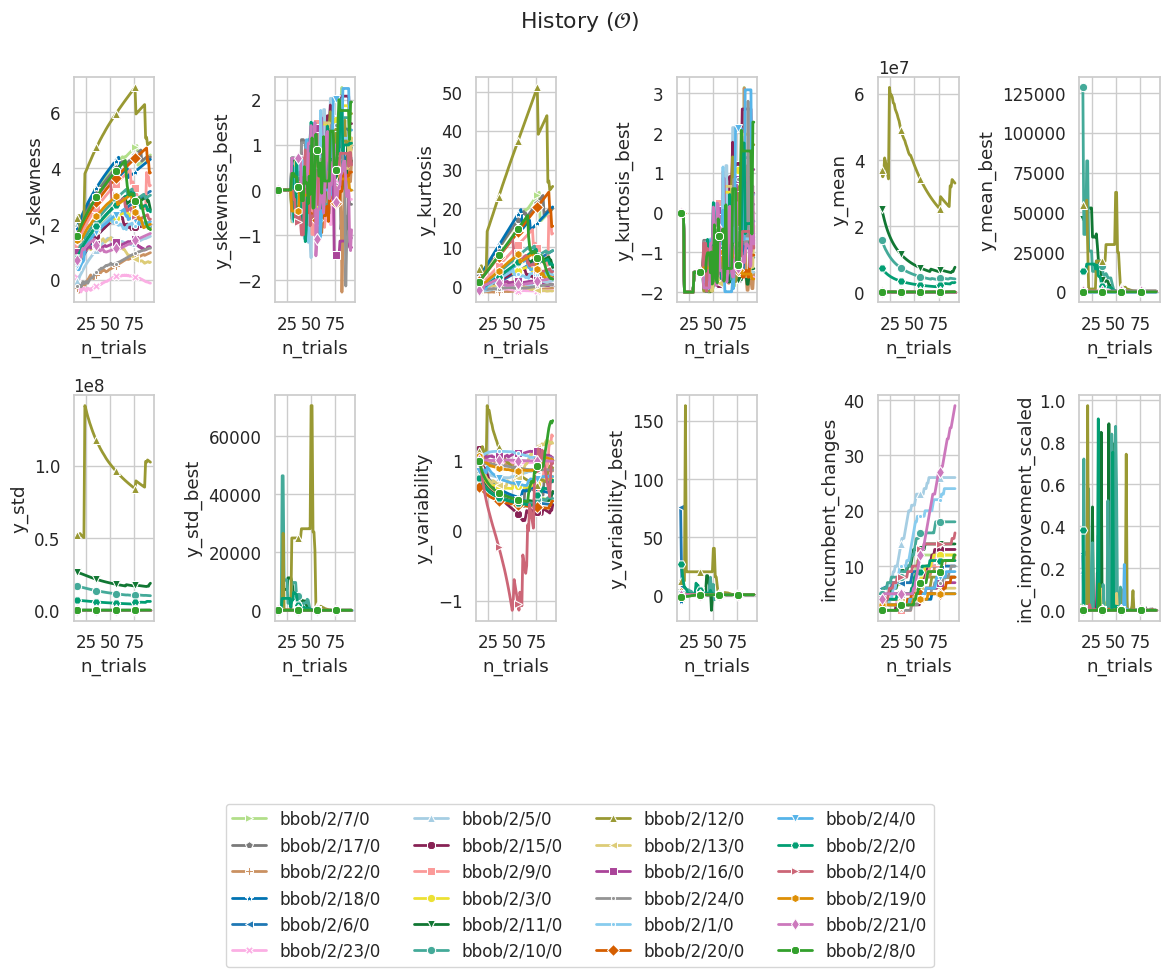

           INFO     Too many optimizers: 24 > 16. Reusing markers.                                      ]8;id=943448;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/utils.py\utils.py]8;;\:]8;id=256888;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/utils.py#47\47]8;;\

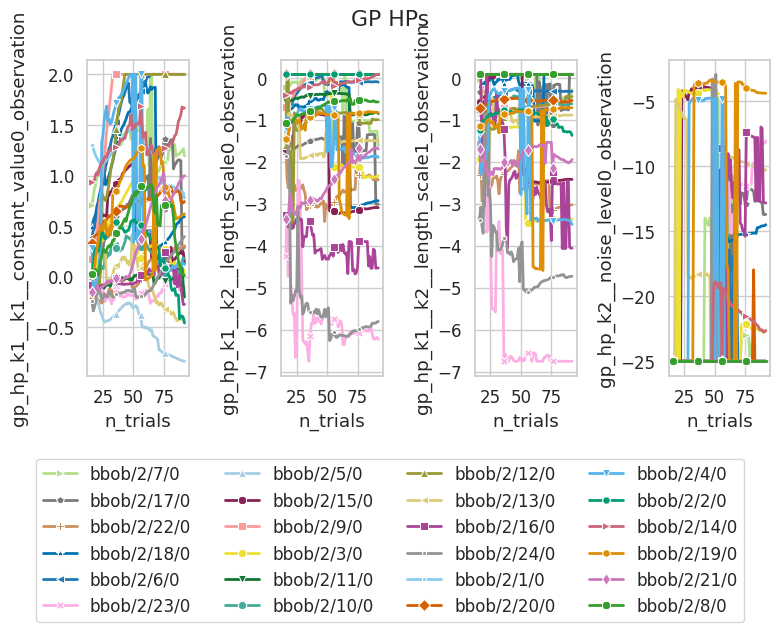

In [55]:
import math
from carps.analysis.utils import setup_seaborn, get_marker_palette, savefig

setup_seaborn(font_scale=1.1)

# (3): single S over time over bbob 20, jump
task_id = "bbob/2/20/0"
group = obs[
    # (obs["task_id"] == task_id) & \
    (obs["seed"] == seed) & \
    (obs["action_space_id"] == "WEI-cont") & \
    (obs["optimizer_id"] == "Jump-0.5")
]
keys_progress = [
    "trials_passed",
    "trials_left",
    "budget_percentage"
]
keys_model = [
    "ubr",
    "ubr_difference"
]
keys_search_space = [
    "searchspace_dim",
    "continuous_hps",
    "categorical_hps",
    "ordinal_hps",
    "int_hps",
    "has_categorical_hps"
]
keys_xhist = [
    "tsp",
    "tsp_best",
    "knn_entropy",
    "knn_entropy_best",
    "knn_difference"
]
keys_yhist = [
    "y_skewness",
    "y_skewness_best",
    "y_kurtosis",
    "y_kurtosis_best",
    "y_mean",
    "y_mean_best",
    "y_std",
    "y_std_best",
    "y_variability",
    "y_variability_best",
    "incumbent_changes",
    "inc_improvement_scaled",
]
keys_gp = [
 "gp_hp_k1__k1__constant_value0_observation",
 "gp_hp_k1__k2__length_scale0_observation",
 "gp_hp_k1__k2__length_scale1_observation",
 "gp_hp_k2__noise_level0_observation",
]
assert len(obs_keys) == len(keys_progress + keys_search_space + keys_model + keys_xhist + keys_yhist + keys_gp)

def plot_states(group, keys, title, cols_max=4):
    ncols = min(cols_max, len(keys))
    nrows = math.ceil(len(keys) / ncols)
    axwidth = 2
    axheight = 2.5
    legendspace = 2
    fig = plt.figure(figsize=(axwidth * ncols, axheight * nrows + legendspace))
    axes = fig.subplots(ncols=ncols, nrows=nrows)
    task_ids = list(group["task_id"].unique())
    palette = get_color_palette(optimizers=task_ids)
    marker_palette = get_marker_palette(optimizers=task_ids)
    for i, key in enumerate(keys):
        ax = axes.flat[i]
        ax = sns.lineplot(
            data=group,
            x="n_trials",
            y=key,
            hue="task_id",
            palette=palette,
            ax=ax,
            linewidth=2,
            style="task_id",
            dashes=False,
            markers=marker_palette,
            markevery=20
        )
        ax.legend().remove()

    legend = ax.legend()
    fig.suptitle(title)
    fig.legend(
        handles=legend.legend_handles,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.4),
        ncols=4,
    )
    legend.remove()
    fig.tight_layout()
    savefig(fig=fig, filename=f"figures/state_space/single/{title}")
    plt.show()

cols_max = 6
print(group.columns)
plot_states(group, keys_progress, "Progress", cols_max=cols_max)
plot_states(group, keys_model, "Model", cols_max=cols_max)
plot_states(group, keys_search_space, "Search Space", cols_max=cols_max)
plot_states(group, keys_xhist, "History ($\\Lambda$)", cols_max=cols_max)
plot_states(group, keys_yhist, "History ($\\mathcal{O}$)", cols_max=cols_max)
plot_states(group, keys_gp, "GP HPs", cols_max=cols_max)


In [ ]:

if "x_1,pca" not in obs.columns:
    obs = apply_pca_reduction(obs, obs_keys)

for task_id, group in obs.groupby("task_id"):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax = sns.scatterplot(
        data=group,
        x="x_0,pca",
        y="x_1,pca",
        hue="policy_id",
        style="seed"
    )

    ax.set_title(f"State Space (PCA(n=2))\n{task_id}")
    ax.legend(bbox_to_anchor=(1.05, 1))
    plt.show()
